Så det er vel et empirisk spørgsmål om (0,0) skal væk. Men i rapporten tror jeg det gav meget bedre resultater. MEN hvis du fjerner dem ka ndu ikke mere sammenligne billeder på tværs af kodere....

- Tjek forskel på hvor mange (0,0)' er hver kodere har
- Tjek forskel på om du beholder (0,0) eller ej ift. meningsfulde resultater.
- Tjek om du bliver nød til
- Du har tre forskellige mål. Du skal se hvilke der giver mest meningsfulde resultater
- Test om en ensample er bedere og hvor meget de tre resultater corrolere.

**so now**:
Make a for loop going over all features for all coders (right now just 1 and 3) and save this jazz in some nice format.

In [1]:
# can run from base

import os
import pickle

# from functions import * # import util functions
from collections import Counter
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import choix

from IPython.display import clear_output

In [2]:
def get_df(att_dict = 1):
    """att_dict should be 1,2,3"""

    path = "/home/simon/Documents/Bodies/data/RA/att_dicts"

    file_name1 = "pregenerated_indx_list.pkl"
    file_path = os.path.join(path, file_name1)

    # Open the file in binary mode
    with open(file_path, 'rb') as file:
        
        # Call load method to deserialze
        pregenerated_indx_list = pickle.load(file)

    file_name2 = f"att_dict_{att_dict}.pkl"
    file_path = os.path.join(path, file_name2)

    if os.path.exists(file_path):

        # Open the file in binary mode
        with open(file_path, 'rb') as file:
        
            # Call load method to deserialze
            att_dict = pickle.load(file)

        df_img = pd.DataFrame(pregenerated_indx_list, columns=['img1', 'img2'])
        df_att = pd.DataFrame(att_dict, columns= att_dict.keys())
        df_att.drop(['indx_indicator'], axis=1, inplace= True)
        df = df_att.join(df_img)

        columns_dict= { 'att0' : 'negative_emotions_t1', 'att1': 'negative_emotions_t2', 'att2': 'mass_protest', 
                        'att3': 'damaged_property', 'att4': 'privat', 'att5': 'public', 
                        'att6': 'militarized', 'att7': 'rural', 'att8': 'urban', 'att9': 'formal' }

        df.rename(columns= columns_dict, inplace= True)

    else: 
        print('That att_dict does not exist. Use 1, 2, or 3.')

    return(df)



In [8]:
def print_zero_ratio(df):

    print("Ratio of (0,0)'s in each feature:\n")

    for i in df.columns[:-2]:
        ratio = (df[i] == (0,0)).sum() / df.shape[0]
        print(f'{i}: {ratio*100:.3}%')

    print('\n')


In [4]:
def analyse_network(G, plot = True):

    print(f'Number of edges: {len(G.edges)}') # same as len(indx_list)
    print(f'Number of nodes: {len(G.nodes)}') # same as len(indx_list)
    print(f'Connected network: {nx.is_connected(G)}')

    G_degrees = list(dict(G.degree).values())

    print(f'Mean degrees: {np.mean(G_degrees)}')
    print(f'Min degrees: {np.min(G_degrees)}')
    print(f'Max degrees: {np.max(G_degrees)}')

    if plot == True:

        plt.figure(figsize=[20,5])

        plt.subplot(1,3,1)
        plt.title('network random layout')
        nx.draw(G, pos=nx.random_layout(G), node_size = 50, node_color = 'blue', alpha = 0.2, width = 0.5, edge_color = 'black')

        plt.subplot(1,3,2)
        plt.title('network spring layout')
        nx.draw(G, pos=nx.spring_layout(G), node_size = 50, node_color = 'blue', alpha = 0.2, width = 0.5, edge_color = 'black')

        plt.subplot(1,3,3)
        plt.title('network degree distribution')
        plt.hist(G_degrees, density=True, bins= 50)
        sns.kdeplot(G_degrees)

        plt.show()

In [5]:
# def check_networks(df):
#     for i in df.columns():
#         sub_df = df[i]
#         edge_list = list(zip(sub_df['img1'], sub_df['img2']))
#         g = nx.Graph()
#         g.add_edges_from(edge_list)
#         print(i)
#         analyse_network(g, True)

In [7]:
def get_non_draw_connected_sub_df(df, att):

    # remove draws
    non_draw_sub = df[(df[att] != (0,0)) & (df[att] != (1,1))][[att, 'img1', 'img2']]

    # get edge list from non-draw subset
    edge_list_non_zero = list(zip(non_draw_sub['img1'], non_draw_sub['img2']))

    # Full graph g
    g = nx.Graph()
    g.add_edges_from(edge_list_non_zero)

    # Get larges connected subset:
    connected_img = sorted(nx.connected_components(g), key = len, reverse=True)[0] # take the larges connected component - really the list you need.

    edge_list_connected = [(node1, node2) for node1, node2 in edge_list_non_zero if node1 in connected_img or node2 in connected_img]


    # Larges connected subgraph gc - just to check
    gc = nx.Graph()
    gc.add_edges_from(edge_list_connected)
    analyse_network(gc, False)

    # sub df

    non_draw_connected_sub_df = non_draw_sub[(non_draw_sub['img1'].isin(connected_img)) | (non_draw_sub['img2'].isin(connected_img))]

    return(non_draw_connected_sub_df) 

#edge_list_non_zero = list(zip(att_sub_df['img1'], att_sub_df['img2']))


In [56]:
def get_input_data(df, att):

    non_draw_connected_sub_df = get_non_draw_connected_sub_df(df, att)

    img_list = list(set(list(non_draw_connected_sub_df['img1']) +  list(non_draw_connected_sub_df['img2'])))
    n_imgs = len(img_list)
    img_idx_generator = img_list.index

    data = []

    for i in range(non_draw_connected_sub_df.shape[0]):

        img1_name = non_draw_connected_sub_df['img1'].iloc[i]
        img2_name = non_draw_connected_sub_df['img2'].iloc[i]

        img1_idx = img_idx_generator(img1_name)
        img2_idx = img_idx_generator(img2_name)

        
        if non_draw_connected_sub_df[att].iloc[i][0] > non_draw_connected_sub_df[att].iloc[i][1]:
            directed_edge = (img1_idx, img2_idx)
            data.append(directed_edge)

        elif non_draw_connected_sub_df[att].iloc[i][0] < non_draw_connected_sub_df[att].iloc[i][1]:
            directed_edge = (img2_idx, img1_idx)
            data.append(directed_edge)

        else: 
            print(f'something wrong w/ edge')
            pass

    return(data, n_imgs, img_list)

In [57]:
def get_att_data_dict(df):

    att_data_dict = {}

    for att in df.columns[:-2]:

        print(att)
        
        data, n_imgs, img_list = get_input_data(df, att)

        att_data_dict[f'{att}_data'] = data
        att_data_dict[f'{att}_n'] = n_imgs
        att_data_dict[f'{att}_img_list'] = img_list


    return(att_data_dict)

In [58]:
df1 = get_df(1)
print_zero_ratio(df1)
att_data_dict = get_att_data_dict(df1)


Ratio of (0,0)'s in each feature:

negative_emotions_t1: 19.5%
negative_emotions_t2: 14.2%
mass_protest: 58.1%
damaged_property: 25.5%
privat: 2.01%
public: 1.6%
militarized: 34.2%
rural: 1.4%
urban: 1.27%
formal: 6.09%


negative_emotions_t1
Number of edges: 5638
Number of nodes: 2092
Connected network: True
Mean degrees: 5.390057361376673
Min degrees: 1
Max degrees: 14
negative_emotions_t2
Number of edges: 6008
Number of nodes: 2113
Connected network: True
Mean degrees: 5.686701372456223
Min degrees: 1
Max degrees: 13
mass_protest
Number of edges: 2900
Number of nodes: 1766
Connected network: True
Mean degrees: 3.2842582106455267
Min degrees: 1
Max degrees: 13
damaged_property
Number of edges: 5213
Number of nodes: 2101
Connected network: True
Mean degrees: 4.962398857686816
Min degrees: 1
Max degrees: 13
privat
Number of edges: 6863
Number of nodes: 2118
Connected network: True
Mean degrees: 6.480642115203022
Min degrees: 1
Max degrees: 17
public
Number of edges: 6890
Number of node

In [59]:
data = att_data_dict['negative_emotions_t1_data']
n_imgs = att_data_dict['negative_emotions_t1_n']

lsr_mean = choix.ilsr_pairwise(n_imgs, data, alpha=0.01) # 10-20 sec
print('lsr done')
mm_mean = choix.mm_pairwise(n_imgs, data, alpha=0.01) # 2 ish min
print('mm done')
# eb_mean, eb_cov = choix.ep_pairwise(n_imgs, data, alpha=0.01, model = 'logit') # 20 ish min

lsr done
mm done


In [63]:
result_dict = {'lsr_mean' : lsr_mean, 'mm_mean' : mm_mean , 'img' : att_data_dict['negative_emotions_t1_img_list']}
results_df = pd.DataFrame(result_dict)

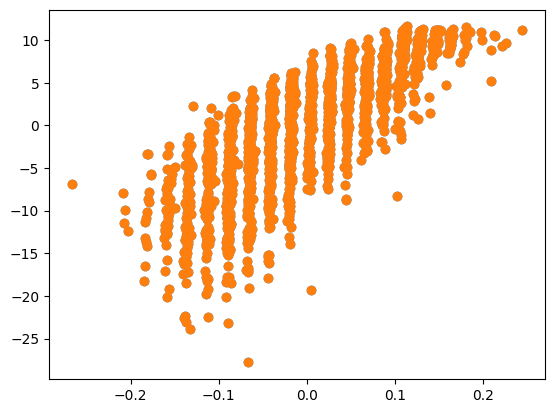

In [65]:
x = results_df['lsr_mean']
y = results_df['mm_mean']
plt.scatter(x,y)
plt.show()

array([ 911, 1703, 1799, ..., 1095, 1525,   89])

In [49]:
pd.DataFrame([lsr_mean, np.argsort(lsr_mean)])

,0,1,2,3,4,5,6,7,8,9,...,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091
0,0.087709,0.086265,-0.064362,0.024079,-0.018057,0.161721,0.068731,-0.040155,-0.018257,0.123057,...,-0.019638,-0.089952,-0.09042,-0.090748,-0.063635,0.109526,0.131916,0.024968,-0.041322,0.084851
1,911.000000,1703.000000,1799.000000,1351.000000,215.000000,1212.000000,863.000000,1981.000000,48.000000,1780.000000,...,1106.000000,279.000000,1476.00000,939.000000,516.000000,1354.000000,1426.000000,1095.000000,1525.000000,89.000000


In [53]:


n_items = 5
data = [
    (4, 0), (1, 0), (3, 1),
    (0, 2), (4, 2), (4, 3),
]

params = choix.ilsr_pairwise(n_items, data, alpha = 0.1)
print(params)

print("ranking (worst to best):", np.argsort(params, ))

[-0.40840352  0.14270428 -1.24642299  0.43236091  1.07976133]
ranking (worst to best): [2 0 1 3 4]


# old:

In [16]:
data, n_imgs = get_input_data(df1, 'negative_emotions_t1')

Number of edges: 5638
Number of nodes: 2092
Connected network: True
Mean degrees: 5.390057361376673
Min degrees: 1
Max degrees: 14


In [17]:
data

[(1616, 1703),
 (1967, 1616),
 (1967, 567),
 (864, 567),
 (657, 1788),
 (1967, 1788),
 (1967, 931),
 (931, 1703),
 (931, 1465),
 (1788, 1465),
 (864, 1788),
 (864, 1967),
 (567, 1465),
 (864, 931),
 (318, 1616),
 (1268, 1788),
 (318, 567),
 (657, 1465),
 (567, 1703),
 (598, 686),
 (1178, 598),
 (318, 1178),
 (686, 1703),
 (1268, 1703),
 (932, 657),
 (932, 598),
 (1268, 686),
 (598, 409),
 (1178, 409),
 (318, 598),
 (932, 1178),
 (1268, 318),
 (1268, 409),
 (932, 409),
 (1178, 1859),
 (932, 72),
 (616, 72),
 (616, 1859),
 (314, 1859),
 (616, 1112),
 (616, 1203),
 (1203, 1112),
 (314, 616),
 (314, 1112),
 (1203, 759),
 (1859, 1231),
 (1808, 1112),
 (314, 759),
 (314, 72),
 (1203, 1462),
 (1203, 1894),
 (1808, 1390),
 (708, 1390),
 (1808, 706),
 (708, 706),
 (1390, 706),
 (708, 62),
 (1725, 708),
 (1725, 143),
 (1725, 46),
 (554, 46),
 (554, 1931),
 (1725, 554),
 (142, 62),
 (1725, 1931),
 (143, 513),
 (142, 109),
 (1094, 513),
 (142, 1558),
 (1094, 109),
 (142, 1312),
 (554, 1312),
 (123

In [14]:

df3 = get_df(3)
print_zero_ratio(df3)
df_dict3 = get_non_zero_dfs(df3)

Ratio of (0,0)'s in each feature:

negative_emotions_t1: 19.5%
negative_emotions_t2: 14.2%
mass_protest: 58.1%
damaged_property: 25.5%
privat: 2.01%
public: 1.6%
militarized: 34.2%
rural: 1.4%
urban: 1.27%
formal: 6.09%
Ratio of (0,0)'s in each feature:

negative_emotions_t1: 71.3%
negative_emotions_t2: 59.0%
mass_protest: 82.5%
damaged_property: 35.8%
privat: 2.42%
public: 2.15%
militarized: 40.6%
rural: 30.6%
urban: 6.91%
formal: 82.4%


In [ ]:
check_networks(df_dict1)
check_networks(df_dict3)

n_items: number of nodes/images
data: list of edges as list of touples (i,j) where i wins over j.

In [ ]:
df_dict1['negative_emotions_t1']

In [77]:
att = 'negative_emotions_t1'

sub_df = df_dict1[att]
img_list = list(set(list(sub_df['img1']) +  list(sub_df['img2'])))
n_imgs = len(img_list)
img_idx_generator = img_list.index

data = []

for i in range(sub_df.shape[0]):

    img1_name = sub_df['img1'].iloc[i]
    img2_name = sub_df['img2'].iloc[i]

    img1_idx = img_idx_generator(img1_name)
    img2_idx = img_idx_generator(img2_name)

    
    if sub_df[att].iloc[i][0] > sub_df[att].iloc[i][1]:
        directed_edge = (img1_idx, img2_idx)
        data.append(directed_edge)

    elif sub_df[att].iloc[i][0] < sub_df[att].iloc[i][1]:
        directed_edge = (img2_idx, img1_idx)
        data.append(directed_edge)

    else: 
        print(f'something wrong w/ edge: {sub_df[att].iloc[i][0]}, {sub_df[att].iloc[i][1]}')
        pass


something wrong w/ edge: 1, 1
something wrong w/ edge: 1, 1
something wrong w/ edge: 1, 1
something wrong w/ edge: 1, 1


In [82]:
    # ca 25 min for negative_emotions_t1 given dict 1
    lsr_mean = choix.ilsr_pairwise(n_imgs, data, alpha=0.01)
    mm_mean = choix.mm_pairwise(n_imgs, data, alpha=0.01) 
    eb_mean, eb_cov = choix.ep_pairwise(n_imgs, data, alpha=0.01, model = 'logit')

In [84]:
lsr_mean

2092

In [85]:
mm_mean

array([  5.83728757,   8.58344607,   5.71997799, ...,  -2.9460575 ,
       -10.73474379,  -4.45904013])

In [86]:
eb_mean

array([  7.2463196 ,   9.76747149,   5.72215712, ...,  -5.12528656,
       -11.55515833,  -7.94896683])

In [87]:
eb_cov

array([[1.69078604e+01, 3.34280681e-03, 5.23566589e-03, ...,
        2.67077192e-03, 6.40721044e-01, 1.70093288e-01],
       [3.34280681e-03, 3.30742067e+01, 7.53277065e-03, ...,
        3.54446904e-03, 5.74427900e-03, 3.95063583e-03],
       [5.23566589e-03, 7.53277065e-03, 2.28158261e+01, ...,
        4.59635539e-01, 4.61181529e-03, 1.28422973e-02],
       ...,
       [2.67077192e-03, 3.54446904e-03, 4.59635539e-01, ...,
        2.88016948e+01, 4.40178588e-03, 3.41152168e-03],
       [6.40721044e-01, 5.74427900e-03, 4.61181529e-03, ...,
        4.40178588e-03, 3.82817271e+01, 1.14147052e-02],
       [1.70093288e-01, 3.95063583e-03, 1.28422973e-02, ...,
        3.41152168e-03, 1.14147052e-02, 3.95275973e+01]])

# OLD

In [ ]:
def get_non_zero_dfs(df):

    df_dict = {}

    for i in df.columns[:-2]:
        df_dict[i] = df[df[i] != (0,0)][['img1', 'img2', i]]

    return(df_dict)

In [ ]:
def get_Gs(att_list):

    """Sub-funciton for .... fits in ...."""

    att_sub_df = att_list.copy() # this zero must be an i to iterate over..

    edge_list_non_zero = list(zip(att_sub_df['img1'], att_sub_df['img2']))

    # Full graph g
    g = nx.Graph()
    g.add_edges_from(edge_list_non_zero)

    # Get larges connected subset:
    connected_img = sorted(nx.connected_components(g), key = len, reverse=True)[0] # take the larges connected component

    edge_list_connected = []

    for i, j in edge_list_non_zero:    
        if i in connected_img or j in connected_img: # should only ned one, but better safe than sorry
            edge_list_connected.append((i,j))

    # Larges connected subgraph gc
    gc = nx.Graph()
    gc.add_edges_from(edge_list_connected)

    return(g, gc, att_sub_df)

# g, gc, att_sub_df = get_Gs(att_list[0])

In [ ]:
def get_att_sub_df_connected(att_sub_df, gc): # not a good name, but is is describtive..

    """Sub-funciton for .... fits in ...."""

    #emo_connected_list = list(gc.nodes) # you need the len of this later
    connected_img_list = list(gc.nodes) # list of all img in the larges connected network
    n = len(connected_img_list)

    att_sub_df_connected = att_sub_df[att_sub_df['img1'].isin(connected_img_list) | att_sub_df['img2'].isin(connected_img_list)].reset_index(drop = True)

    return(att_sub_df_connected, n)


In [ ]:
def get_data(att_sub_df_connected):

    """Sub-funciton for .... fits in ...."""

    # list of all unique images left in the larges connected network
    img_list = list(set(list(att_sub_df_connected['img1']) +  list(att_sub_df_connected['img2']))) # call something better
    data = []

    for row in att_sub_df_connected.iterrows():

        img1_idx = img_list.index(row[1]['img1']) # row 0 is somthing else..
        img2_idx = img_list.index(row[1]['img2'])

        if row[1][-1][0] > row[1][-1][1]:# img1_idx gets to go first 
            att_idx = (img1_idx, img2_idx)

        else:# img2_idx gets to go first
            att_idx = (img2_idx, img1_idx)

        data.append(att_idx)

    return(data, img_list)


In [ ]:
def get_att_dict(att_list, plot = True):

    att_dict = {}

    for att_df in att_list:
        att_name = att_df.columns[-1]

        g, gc, att_sub_df = get_Gs(att_df)
        att_sub_df_connected, n =  get_att_sub_df_connected(att_sub_df, gc)
        data, img_list = get_data(att_sub_df_connected)

        sub_dict = {'data' : data, 'img_list' : img_list, 'n': n}

        att_dict[att_name] = sub_dict

        # plotting the two networks
        if plot == True:
            print(att_name)
            plot_networks(att_name = att_name, g=g, gc=gc)

    return(att_dict)

In [ ]:
att_dict = get_att_dict(att_list)

In [ ]:
plot = True

df_score_dict = {}

for  att in df.columns[2:]:
    
    data = att_dict[att]['data']
    img_list = att_dict[att]['img_list']
    n = att_dict[att]['n']

    start = time.time()

    lsr_mean = choix.ilsr_pairwise(n, data, alpha=0.01)
    mm_mean = choix.mm_pairwise(n, data, alpha=0.01) 
    eb_mean, eb_cov = choix.ep_pairwise(n, data, alpha=0.01, model = 'logit')

    end = time.time()
    run_time = (end - start)/60
    print(f'{att} done in {round(run_time,3)} minutes')

    df_score = pd.DataFrame(list(zip(img_list, lsr_mean, mm_mean, eb_mean )), columns=['img', 'lsr_score', 'mm_score', 'eb_score'])
    #df_emo.sort_values('eb_score', ascending = False).head(6) # then we can sees the difference qualitative.

    df_score_dict[att] = df_score

    if plot == True:
        plot_scores(lsr_mean, mm_mean, eb_mean)

